# Reproducing 3D Interactive Figure of DIB SNR Inside/Outside the Local Bubble in Saydjari+2023

### Setup the plotly template options

In [1]:
import numpy as np
import plotly.graph_objects as go
from astropy.table import Table
from plotly.offline import plot
import glob
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib
from astropy.table import vstack
import os
import h5py

DEFAULT_FONT = 'Arial, sans-serif'

import plotly.io as plt_io

# create our custom_dark theme from the plotly_dark template
plt_io.templates["custom_dark"] = plt_io.templates["plotly_dark"]

# set the paper_bgcolor and the plot_bgcolor to a new color
plt_io.templates["custom_dark"]['layout']['paper_bgcolor'] = 'black'
plt_io.templates["custom_dark"]['layout']['plot_bgcolor'] = 'black'

# you may also want to change gridline colors if you are modifying background
plt_io.templates['custom_dark']['layout']['yaxis']['gridcolor'] = 'black'
plt_io.templates['custom_dark']['layout']['xaxis']['gridcolor'] = 'black'

data = []

# make figure
fig_dict = {
    "data": [],
    "layout": {}}

### Setup the plotly layout parameters

In [3]:
fig_dict['layout'] = go.Layout(
    margin=dict(r=50, l=50, b=50, t=50),  # noqa
    width=1400,
    scene=dict(
        xaxis=dict(
            title='X [pc]',
            titlefont=dict(
                family=DEFAULT_FONT,
                size=20,
                color='#686868'
            ),
            showspikes=False,
            showgrid=True,
            showline=True,
            backgroundcolor='black',
            gridcolor='#303030',
            zerolinecolor='#303030',
            showticklabels=True,
            tickfont=dict(
                family=DEFAULT_FONT,
                size=12,
                color='#686868'),
            range=[-400, 400]),
        yaxis=dict(
            title='Y [pc]',
            titlefont=dict(
                family=DEFAULT_FONT,
                size=20,
                color='#686868'), #'#a9a9a9'
            showspikes=False,
            showgrid=True,
            showline=False,
            zerolinecolor='#303030',
            backgroundcolor='black',
            gridcolor='#303030',
            range=[-400, 400],
            showticklabels=True,
            tickfont=dict(
                family=DEFAULT_FONT,
                size=12,
                color='#686868'),
        ),
        zaxis=dict(
            title='Z [pc]',
            titlefont=dict(
                family=DEFAULT_FONT,
                size=20,
                color='#686868'),
            showspikes=False,
            showgrid=True,
            showline=False,
            zerolinecolor='gold',
            zerolinewidth=5,
            backgroundcolor='black',
            gridcolor='#303030',
            range=[-400, 400],
            showticklabels=True,
            tickfont=dict(
                family=DEFAULT_FONT,
                size=12,
                color='#686868'),
        ),
        aspectratio=dict(x=1*1.65, y=1*1.65,z=1*1.65),))

### Plot the Leike+2020 3D dust data with Densities > 10 cm^-3 as a 3D point cloud

In [4]:
tl = Table.read("../support/3D_Dust_10cc_Leike2020.fits")
tl.sort('ys')
dustlayer = go.Scatter3d(x = tl['xs'][::20],
                            y = tl['ys'][::20],
                            z = tl['zs'][::20],
                            mode="markers",
                            marker = dict(size = 6, color = 'gray'),
                            opacity=0.015,
                            showlegend=True,
                            visible = True,
                            legendgroup='dust',
                            hoverinfo='skip',
                            name='3D Dust (Leike+2020)')
fig_dict['data'].append(dustlayer)

### Plot a 3D model for the Bubble's Surface from Pelgrims+2020

In [5]:
tb = Table.read("../support/Local_Bubble_Pelgrims2020.fits")
lbubble = go.Scatter3d(x = tb['x'][::10],
                            y = tb['y'][::10],
                            z = tb['z'][::10],
                            marker = dict(size = 6, colorscale =[[0.0, 'rgb(0, 0, 0)'], [0.5, 'rgb(103, 100, 193)'],[1.0, 'rgb(0, 0, 0)']], color =tb['z'][::10],cmin=-300,cmax=300),
                            opacity=0.05,
                            showlegend=True,
                            visible = True,
                            legendgroup='bubble',
                            hoverinfo='skip',
                            name='Local Bubble (Pelgrims+2020)')
fig_dict['data'].append(lbubble)

### Plot the Current Sun Position

In [6]:
sun_current = go.Scatter3d(x=[0], 
                  y=[0], 
                  z=[0], 
                  mode='markers',
                  marker = dict(size = 3 , color = 'yellow', symbol='x'),
                  hoverinfo='text',
                  hovertext=['Sun'],
                  opacity=1,
                  name='Sun',
                  showlegend=True,
                  legendgroup='sun_current',
                  visible=True)
fig_dict['data'].append(sun_current)

In [7]:
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm
import matplotlib.pyplot as plt
import colorcet as cc

f = h5py.File("../dib_explore_v14.h5",'r')

#generate colormap
colorlist = plt.cm.get_cmap("cet_CET_L6_r",512)(np.linspace(0.9,0.5,256))
colorlist = np.append(colorlist,plt.cm.get_cmap("cet_CET_L4_r",512)(np.linspace(0.5,0,256)),axis=0)
cmap_split = mcolors.LinearSegmentedColormap.from_list('mycmap', colorlist, N=512)

#generate colormap normalization
vmin=np.min(f['dib_snr'][:])
vcenter=5
vmax=10
norm = colors.TwoSlopeNorm(vmin=vmin,vcenter=vcenter,vmax=vmax)

#grab RGBA colors of all the detections and convert them to strings to faciltate plotly 3D scatter plotting
rgbas = cmap_split(norm(f['dib_snr'][:]))
rgb_str = [r'{}'.format(mcolors.rgb2hex((rgba[0], rgba[1], rgba[2]))) for rgba in rgbas]


dibs = go.Scatter3d(x = f['X'][:]*1000,
                    y = f['Y'][:]*1000,
                    z = f['Z'][:]*1000,
                    opacity=0.85,
                    mode = 'markers',
                    hoverinfo='text',
                    hovertext=['DIB SNR: {:.1f}<br>EW: {:.2f}<br>VLSR: {:.1f}<br>Sigma: {:.2f}'.format(f['dib_snr'][:][k],f['ew'][:][k],f['v_dust_lsr'][:][k],f['sig'][:][k]) for k in range(0,len(f['X']))],
                    marker = dict(showscale=False,size = 5, color = rgb_str,symbol='circle'),
                    name='DIB Catalog (Saydjari+2022)',
                    showlegend=True,
                    legendgroup='dibs',
                    visible = True)

fig_dict['data'].append(dibs)

### Output to File

In [8]:
fig = go.Figure(fig_dict)

fig.update_layout(showlegend = True, template = 'custom_dark')
fig.layout.legend.font.size = 14
fig.layout.legend.font.color = 'white'
fig.layout.legend.title='Click to Show/Hide:'
fig.layout.legend.title.side='top'
fig.layout.legend.title.font.size=22
fig.update_layout(legend= {'itemsizing': 'constant'})

camera = dict(
    up=dict(x=0, y=0, z=1),
    eye = {'x': -1.25, 'y': -2.0, 'z': 1.25},
    projection=dict(type='orthographic')
)

fig.update_layout(scene_camera=camera)

plot(fig, filename='../figures/DIB_Local_Bubble_SNR.html', auto_open=False, auto_play=False)

'../figures/DIB_Local_Bubble_SNR.html'

### Generate Colorbar to Accompany Plotly Figure

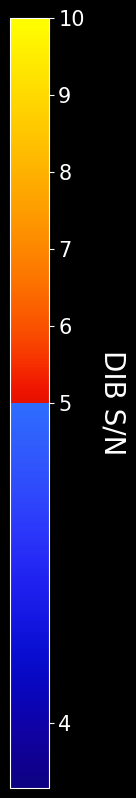

In [10]:
fig = plt.figure(figsize = (10,10))
plt.style.use('dark_background')

plt.scatter(f['X'][:]*1000,f['Y'][:]*1000,c = f['dib_snr'][:],cmap=cmap_split,norm=norm)
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.gca().set_visible(False)
cbar = plt.colorbar()
cbar.ax.set_yticks([ 4.,  5.,  6.,  7.,  8.,  9., 10.])
cbar.set_label('DIB S/N', rotation=270,fontsize=20,labelpad=30)
cbar.ax.tick_params(labelsize=15)
plt.savefig("../figures/dib_snr_cbar.png",dpi=200,bbox_inches='tight')